# Modeling ML- Generated ENSDF Data with Decision Trees for Inference of Isotopes with no Data Avaliable

In [261]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

import sys
import os
import glob
sys.path.append("../..")

import nucml.datasets as nuc_data
import nucml.ensdf.plotting_utils as ensdf_plot
import nucml.ensdf.data_utilities as ensdf_utils
import nucml.ame.parsing_utilities as ame_utils
import nucml.model.model_building as model_building
import nucml.general_utilities as gen_utils

In [352]:
import importlib
importlib.reload(gen_utils)
importlib.reload(nuc_data)
importlib.reload(ensdf_plot)
importlib.reload(model_building)
importlib.reload(ensdf_utils)

<module 'nucml.ensdf.data_utilities' from '../..\\nucml\\ensdf\\data_utilities.py'>

In [163]:
figure_dir = "../Figures/"

# Goal

We already modeled most of the isotopes NLD using a linear model fitted to cut-off ensdf data. However, there are some cases where the cut-off parameteres leave isotopes data-less. We are going to use the linear model generated ENSDF data to generate data for those isotopes were no data is avaliable. Which isotopes do we need to model?

In [204]:
ensdf_df = nuc_data.load_ensdf(append_ame=True, log=True)
ensdf_cutoff_df = nuc_data.load_ensdf(cutoff=True, append_ame=True, log=True)

INFO:root:Reading data from ../../ENSDF/CSV_Files/ensdf.csv
INFO:root:Dropping Ground State...
INFO:root:AME: Reading and loading Atomic Mass Evaluation files from: 
 C:\Users\Pedro\Desktop\ML_Nuclear_Data\AME\CSV_Files\AME_all_merged_no_NaN.csv
INFO:root:Finished. Resulting dataset has shape (72138, 69)
INFO:root:Reading data from ../../ENSDF/CSV_Files/ensdf_cutoff.csv
INFO:root:Dropping Ground State...
INFO:root:AME: Reading and loading Atomic Mass Evaluation files from: 
 C:\Users\Pedro\Desktop\ML_Nuclear_Data\AME\CSV_Files\AME_all_merged_no_NaN.csv
INFO:root:Finished. Resulting dataset has shape (20825, 77)


# Loading ENSDF Data 

The `load_ensdf_ml` function concatenates all the csv files that were generated with the linear models in the previous notebooks. 

In [159]:
ensdf_ml_df, x_train, x_test, y_train, y_test, to_scale, scaler = nuc_data.load_ensdf_ml(
    log=True, append_ame=True, basic=1, num=True, frac=0.3, scaling_type="std")

INFO:root:Dropping Ground State...
INFO:root:AME: Reading and loading Atomic Mass Evaluation files from: 
 C:\Users\Pedro\Desktop\ML_Nuclear_Data\AME\CSV_Files\AME_all_merged_no_NaN.csv
INFO:root:Dropping unnecessary features and one-hot encoding categorical columns...
INFO:root:Splitting dataset into training and testing...
INFO:root:Normalizing dataset...
INFO:root:Fitting new scaler.
INFO:root:Finished. Resulting dataset has shape (3325100, 12), Training and Testing dataset shapes are (2327570, 11) and (997530, 11) respesctively.


In [160]:
# u233 = ensdf_utils.load_ensdf_samples(ensdf_ml_df, 92, 233, scale=False, scaler=None, to_scale=[])

# u233_exp = ensdf_utils.append_ensdf_levels(100, ensdf_ml_df, 92, 235)

# Decision Trees

We will try to fit a DT regressor with default parameters. 
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [161]:
from sklearn import tree

In [162]:
dt_rgr = tree.DecisionTreeRegressor(max_depth=38, criterion='mse')
dt_rgr.fit(x_train, y_train)
print("The depth of the three is: ", dt_rgr.get_depth())

The depth of the three is:  38


# Making Predictions

Notice we will use the `endf_df` dataframe rather than the original `ensdf_ml_df` dataframe to directly compare the fit with the original ENSDF data to get our performance metrics. 

INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (151, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:Scaling dataset...
INFO:root:ENSDF extracted DataFrame has shape: (151, 12)


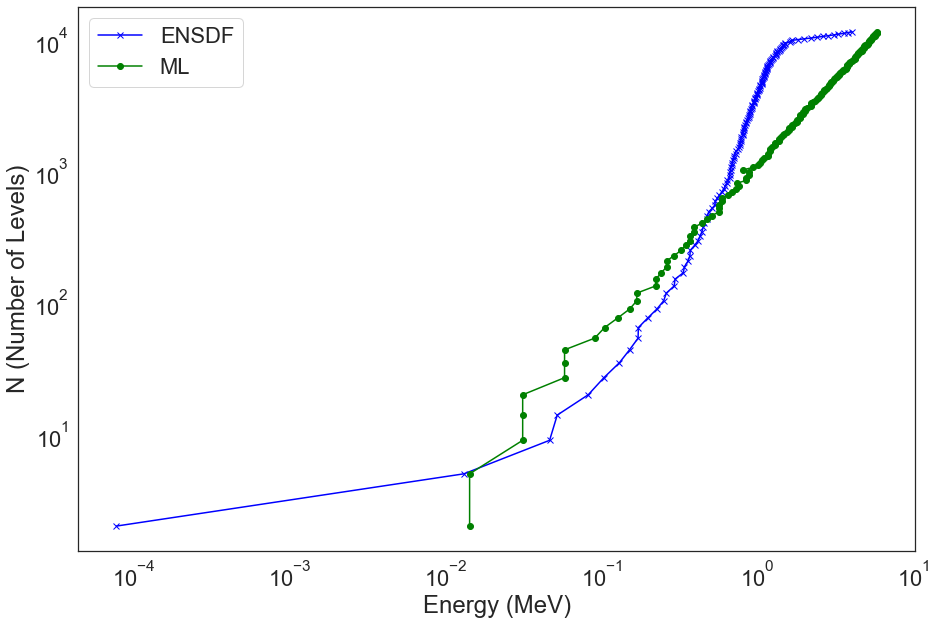

In [184]:
# original, pred = ensdf_utils.make_predictions_from_df_v2(
#     ensdf_ml_df, 92, 235, dt_rgr, None, scaler=scaler, 
#     to_scale=to_scale, log=True, plot=True, save=False,
#     save_dir=figure_dir)

original, pred = ensdf_utils.make_predictions_from_df(
    ensdf_df[ensdf_ml_df.columns], 92, 235, dt_rgr, None, scaler=scaler, 
    to_scale=to_scale, log=True, plot=True, save=False,
    save_dir=figure_dir)

In [369]:
# infer = ensdf_utils.make_predictions_w_levels(
#     ensdf_ml_df, 92, 235, 150, dt_rgr, None, scaler=scaler, 
#     to_scale=to_scale, log=True, plot=True, save=False,
#     save_dir=figure_dir)

# infer = ensdf_utils.make_predictions_w_levels(
#     ensdf_df[ensdf_ml_df.columns], 92, 235, 100, dt_rgr, None, scaler=scaler, 
#     to_scale=to_scale, log=True, plot=True, save=False,
#     save_dir=figure_dir)

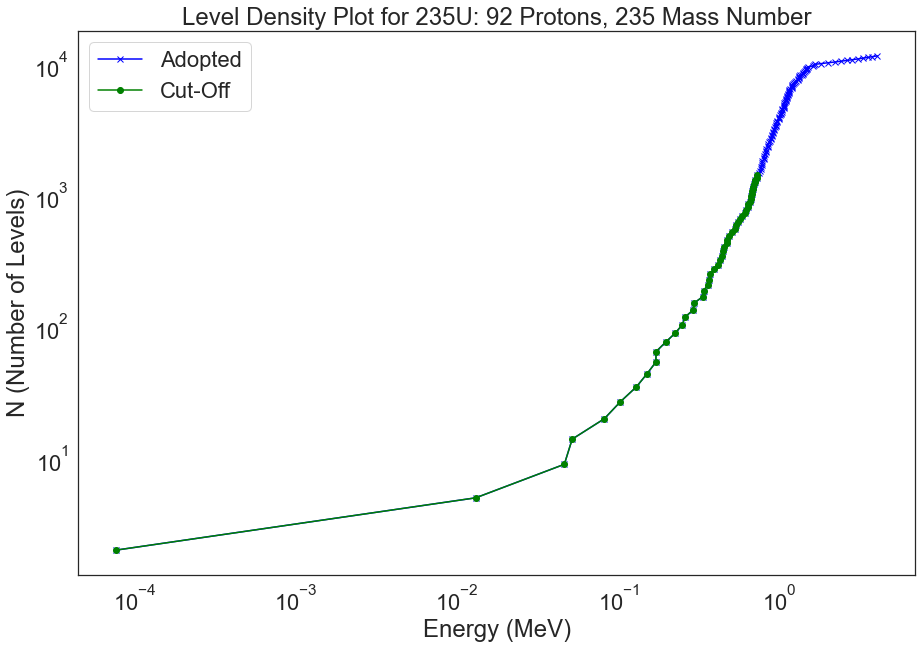

In [213]:
ensdf_plot.plot_level_density(92, 235, ensdf_df, ensdf2=ensdf_cutoff_df, log=True)

It appears the model is capturing the linear behaviour due to to the linear-dt combination. Can we now use the model to generate a few datapoints for our linear model to generate useful NLD data?

# Extrapolating to Unknown Isotopes

We were able to fit a linear model for almsot every element, however there are some isotopes for which we missed due to no data in ENSDF or other reasons. Which elements do we need data for? Fortunatly we have a list of all isotopes in EXFOR and we know that all isotopes in ensdf_cutoff_df were modeled. The difference between these two lists are the isotopes with no data that we need to model.

In [ ]:
from natsort import natsorted

In [372]:
no_data_isotopes = np.setdiff1d(nuc_data.exfor_elements, ensdf_cutoff_df[ensdf_cutoff_df.Level_Energy != 0].Target_Element_w_A.values)
# yields the elements in `first list` that are NOT in `second list`

no_data_isotopes = natsorted(no_data_isotopes)
print(len(no_data_isotopes))
natsorted(no_data_isotopes)[:10]

41


['1H', '2H', '3H', '3He', '4He', '6Li', '7Be', '7Li', '8Li', '25Ne']

There are 41 elements which we have no data avaliable. We need to generate data for this isotopes up to 20 MeV to append to EXFOR. Do we have basic data for all these elements in the AME database?

In [373]:
np.setdiff1d(nuc_data.exfor_elements, ame.Target_Element_w_A.values)
# yields the elements in `first list` that are NOT in `second list`

array([], dtype='<U5')

We do have all basic data. Let us grab Lithium 7 and try to predict some values and compare them with the known levels that were eliminated due to the RIPL cut-off parameters. 

INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (9, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (9, 12)
INFO:root:Expanded Dataset has shape: (500, 11)
INFO:root:Scaling dataset...


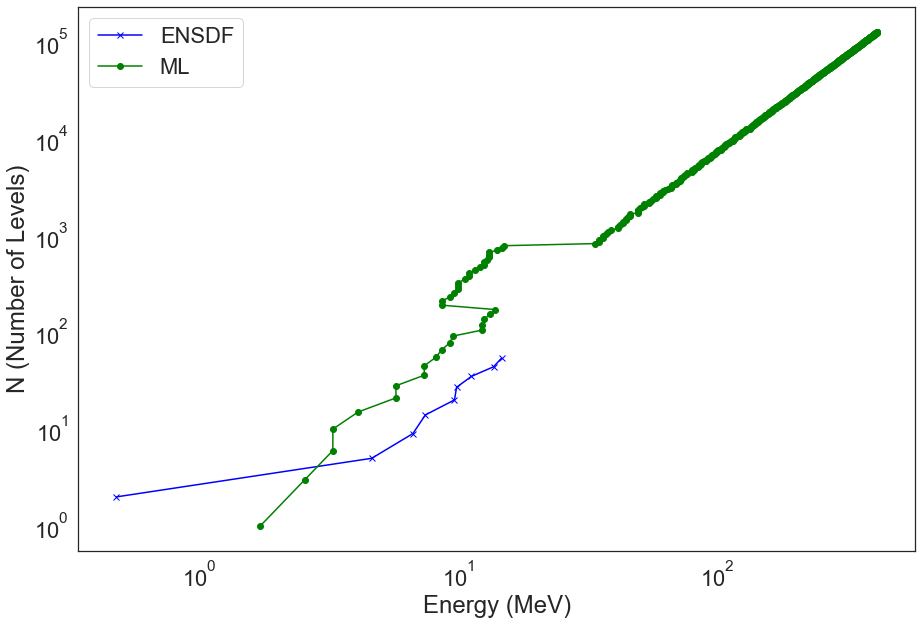

In [374]:
infer = ensdf_utils.make_predictions_w_levels(
    ensdf_df[ensdf_ml_df.columns], 3, 7, 500, dt_rgr, None, scaler=scaler, 
    to_scale=to_scale, log=True, plot=True, save=False,
    save_dir=figure_dir)

In [375]:
# infer = ensdf_utils.make_predictions_w_levels(
#     ensdf_df[ensdf_ml_df.columns], 3, 6, 500, dt_rgr, None, scaler=scaler, 
#     to_scale=to_scale, log=True, plot=True, save=False,
#     save_dir=figure_dir)

In [376]:
element_info = nuc_data.element_info

In [279]:
no_data_isotopes_data = {}
for i in no_data_isotopes:
    protons = element_info["Protons"][i]
    mass_number = element_info["Mass_Number"][i]
    print("{} Protons: {} Mass Number: {}".format(i, protons, mass_number))
    try:
        infer = ensdf_utils.make_predictions_w_levels(
            ensdf_df[ensdf_ml_df.columns], protons, mass_number, 500, dt_rgr, None, scaler=scaler, 
            to_scale=to_scale, log=True, plot=False, save=False, save_dir=figure_dir)

        no_data_isotopes_data[i] = infer
    except Exception:
        no_data_isotopes_data[i] = "no data"
        pass

INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (0, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (0, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (0, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (0, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (0, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (0, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (0, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (0, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (15, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (15, 12

1H Protons: 1 Mass Number: 1
2H Protons: 1 Mass Number: 2
3H Protons: 1 Mass Number: 3
3He Protons: 2 Mass Number: 3
4He Protons: 2 Mass Number: 4
6Li Protons: 3 Mass Number: 6
7Be Protons: 4 Mass Number: 7
7Li Protons: 3 Mass Number: 7
8Li Protons: 3 Mass Number: 8
25Ne Protons: 10 Mass Number: 25
135Cs Protons: 55 Mass Number: 135


INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (10, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (10, 12)
INFO:root:Expanded Dataset has shape: (500, 11)
INFO:root:Scaling dataset...
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (60, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (60, 12)
INFO:root:Expanded Dataset has shape: (500, 11)
INFO:root:Scaling dataset...
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (0, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (0, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (7, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (7, 12)
INFO:root:Expanded Dataset has shape: (500

226Ra Protons: 88 Mass Number: 226
230Pa Protons: 91 Mass Number: 230
231U Protons: 92 Mass Number: 231
232Np Protons: 93 Mass Number: 232
232Pa Protons: 91 Mass Number: 232
233Np Protons: 93 Mass Number: 233
234Np Protons: 93 Mass Number: 234
234Pa Protons: 91 Mass Number: 234
236Np Protons: 93 Mass Number: 236
236Pu Protons: 94 Mass Number: 236


INFO:root:Scaling dataset...
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (1, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (1, 12)
INFO:root:Expanded Dataset has shape: (500, 11)
INFO:root:Scaling dataset...
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (11, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (11, 12)
INFO:root:Expanded Dataset has shape: (500, 11)
INFO:root:Scaling dataset...
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (3, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (3, 12)
INFO:root:Expanded Dataset has shape: (500, 11)
INFO:root:Scaling dataset...
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (10, 12)
INFO:root:Extracting samples from dat

238Am Protons: 95 Mass Number: 238
239Am Protons: 95 Mass Number: 239
240Cm Protons: 96 Mass Number: 240
240Np Protons: 93 Mass Number: 240
241Cm Protons: 96 Mass Number: 241
242Cm Protons: 96 Mass Number: 242
244Bk Protons: 97 Mass Number: 244
244Cm Protons: 96 Mass Number: 244


INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (1, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (1, 12)
INFO:root:Expanded Dataset has shape: (500, 11)
INFO:root:Scaling dataset...
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (0, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (0, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (1, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (1, 12)
INFO:root:Expanded Dataset has shape: (500, 11)
INFO:root:Scaling dataset...
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (0, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (0, 12)
INFO:root:Extracting samples from dataframe.
I

245Bk Protons: 97 Mass Number: 245
246Bk Protons: 97 Mass Number: 246
248Bk Protons: 97 Mass Number: 248
248Es Protons: 99 Mass Number: 248
249Es Protons: 99 Mass Number: 249
250Es Protons: 99 Mass Number: 250
252Cf Protons: 98 Mass Number: 252
253Cf Protons: 98 Mass Number: 253
253Es Protons: 99 Mass Number: 253
254Cf Protons: 98 Mass Number: 254


INFO:root:ENSDF extracted DataFrame has shape: (0, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (0, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (9, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (9, 12)
INFO:root:Expanded Dataset has shape: (500, 11)
INFO:root:Scaling dataset...
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (0, 12)
INFO:root:Extracting samples from dataframe.
INFO:root:ENSDF extracted DataFrame has shape: (0, 12)


254Es Protons: 99 Mass Number: 254
255Es Protons: 99 Mass Number: 255


In [378]:
no_data_isotopes_data["4He"]

,Level_Number,Protons,Neutrons,Mass_Number,Atomic_Mass_Micro,Mass_Excess,Binding_Energy,B_Decay_Energy,S(2n),S(n),S(p),Level_Energy
0,0.000000,-3.165726,-2.669443,-2.858212,-2.855148,2.099508,-4.215314,-8.33687,-0.645548,6.980036,6.090678,0.591697
1,0.301030,-3.165726,-2.669443,-2.858212,-2.855148,2.099508,-4.215314,-8.33687,-0.645548,6.980036,6.090678,0.514280
2,0.477121,-3.165726,-2.669443,-2.858212,-2.855148,2.099508,-4.215314,-8.33687,-0.645548,6.980036,6.090678,0.674829
3,0.602060,-3.165726,-2.669443,-2.858212,-2.855148,2.099508,-4.215314,-8.33687,-0.645548,6.980036,6.090678,0.747905
4,0.698970,-3.165726,-2.669443,-2.858212,-2.855148,2.099508,-4.215314,-8.33687,-0.645548,6.980036,6.090678,0.747905
...,...,...,...,...,...,...,...,...,...,...,...,...
495,2.695482,-3.165726,-2.669443,-2.858212,-2.855148,2.099508,-4.215314,-8.33687,-0.645548,6.980036,6.090678,2.616878
496,2.696356,-3.165726,-2.669443,-2.858212,-2.855148,2.099508,-4.215314,-8.33687,-0.645548,6.980036,6.090678,2.619068
497,2.697229,-3.165726,-2.669443,-2.858212,-2.855148,2.099508,-4.215314,-8.33687,-0.645548,6.980036,6.090678,2.619068
498,2.698101,-3.165726,-2.669443,-2.858212,-2.855148,2.099508,-4.215314,-8.33687,-0.645548,6.980036,6.090678,2.619941


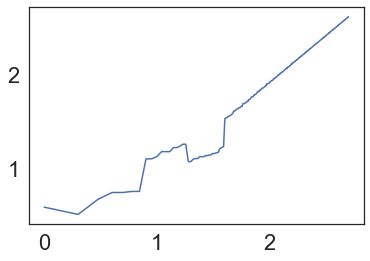

In [381]:
plt.plot(no_data_isotopes_data["4He"].Level_Number, no_data_isotopes_data["4He"].Level_Energy)

In [337]:
unknown_isotopes = []
for element, data in no_data_isotopes_data.items():
    if type(data) == str:
        unknown_isotopes.append(element)
        
unknown_isotopes

['1H',
 '2H',
 '3H',
 '3He',
 '230Pa',
 '232Pa',
 '234Np',
 '246Bk',
 '248Es',
 '254Cf',
 '255Es']

In [338]:
ame = nuc_data.load_ame()
ame = ame.rename(columns={"Element_w_A": "Target_Element_w_A", "Z": "Protons", "N": "Neutrons", "A": "Mass_Number"})

columns_ame = list(x_train.columns[1:])
columns_ame.append("Target_Element_w_A")
ame = ame[columns_ame]

INFO:root:AME: Reading and loading Atomic Mass Evaluation files from: 
 C:\Users\Pedro\Desktop\ML_Nuclear_Data\AME\CSV_Files\AME_all_merged_no_NaN.csv


In [339]:
columns_for_ames = list(ensdf_ml_df.columns)
columns_for_ames.remove("Level_Energy")

In [356]:
def plot_nodata(element):
    new = ame[ame.Target_Element_w_A == element]
    new["Level_Number"] = 1
    new = new[columns_for_ames]

    infer = ensdf_utils.make_predictions_w_levels_nodata(
        new, 100, dt_rgr, None, scaler=scaler, 
        to_scale=to_scale, log=True, plot=True, save=False,
        save_dir=figure_dir, inv_transform=True)
    return infer

for i in unknown_isotopes:
    infer = plot_nodata(i)

In [ ]:
def plot_nodata(element):
    new = ame[ame.Target_Element_w_A == element]
    new["Level_Number"] = 1
    new = new[columns_for_ames]

    infer = ensdf_utils.make_predictions_w_levels_nodata(
        new, 100, dt_rgr, None, scaler=scaler, 
        to_scale=to_scale, log=True, plot=True, save=False,
        save_dir=figure_dir, inv_transform=True)
    
    to_feed = infer.copy()
    to_feed[["Level_Number", "Level_Energy"]] = np.log10(to_feed[["Level_Number", "Level_Energy"]])
    to_feed["Target_Element_w_A"] = '255Es'
    to_feed.head()    
    
    pred_v1 = ensdf_utils.generate_level_density_csv(to_feed, 99, 156, tot_num_levels=500, nodata=True,
                                                     # Notice I want to get the NLD up to a certain energy
                                                     # so we set get_upper=True and the target upper_energy_mev 
                                                     # to 20 MeV. The it_limit means how many times should we 
                                                     # increase the tot_num_levels by 100 before giving up. 
                                                     get_upper=True, upper_energy_mev=20, it_limit=500, 
                                                     plot=True)
    return infer

In [360]:
to_feed = infer.copy()
to_feed[["Level_Number", "Level_Energy"]] = np.log10(to_feed[["Level_Number", "Level_Energy"]])
to_feed["Target_Element_w_A"] = '255Es'
to_feed.head()

,Level_Number,Protons,Neutrons,Mass_Number,Atomic_Mass_Micro,Mass_Excess,Binding_Energy,B_Decay_Energy,S(2n),S(n),S(p),Level_Energy,Target_Element_w_A
0,0.000000,99.0,156.0,255.0,2.550903e+08,84089.274,7437.821,289.62,11063.9,5972.64,4541.1,-1.659831,255Es
1,0.301030,99.0,156.0,255.0,2.550903e+08,84089.274,7437.821,289.62,11063.9,5972.64,4541.1,-1.438257,255Es
2,0.477121,99.0,156.0,255.0,2.550903e+08,84089.274,7437.821,289.62,11063.9,5972.64,4541.1,-1.343576,255Es
3,0.602060,99.0,156.0,255.0,2.550903e+08,84089.274,7437.821,289.62,11063.9,5972.64,4541.1,-1.114423,255Es
4,0.698970,99.0,156.0,255.0,2.550903e+08,84089.274,7437.821,289.62,11063.9,5972.64,4541.1,-1.092488,255Es


In [367]:
importlib.reload(gen_utils)
importlib.reload(nuc_data)
importlib.reload(ensdf_plot)
importlib.reload(model_building)
importlib.reload(ensdf_utils)

<module 'nucml.ensdf.data_utilities' from '../..\\nucml\\ensdf\\data_utilities.py'>

INFO:root:Generating level density for 255Es
INFO:root:Expanded Dataset has shape: (100, 12)


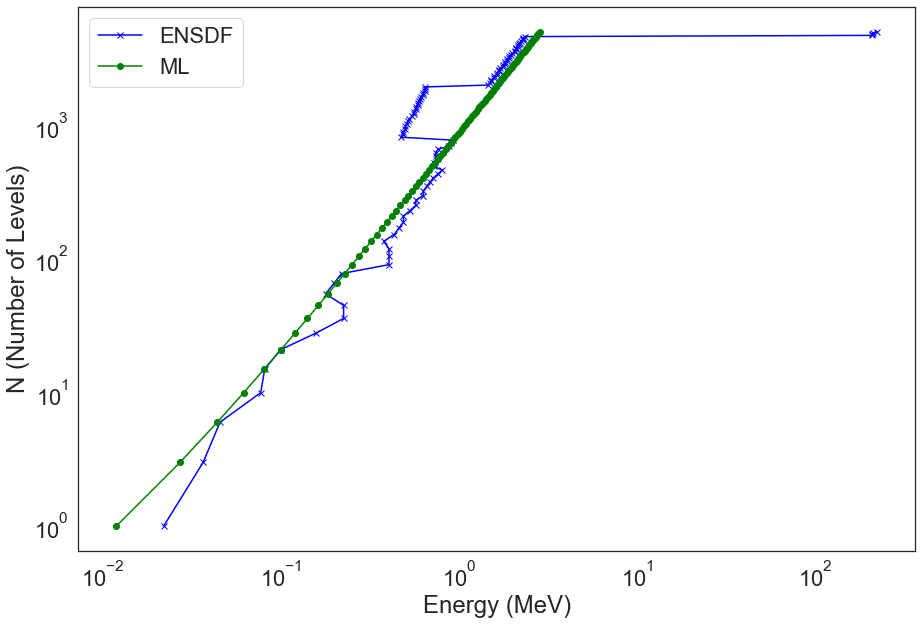

In [365]:
pred_v1 = ensdf_utils.generate_level_density_csv(to_feed, 99, 156, tot_num_levels=100, nodata=True, plot=True)

INFO:root:Generating level density for 255Es
INFO:root:Expanded Dataset has shape: (500, 12)
INFO:root:Initalizing starting variables for NLD extrapolation...
INFO:root:Expanded Dataset has shape: (600, 12)


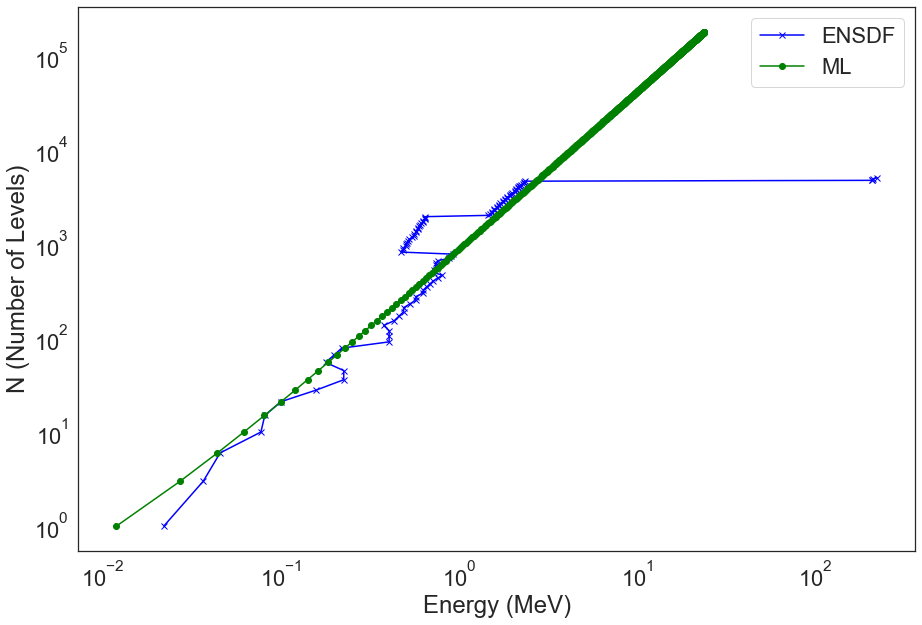

In [368]:
pred_v1 = ensdf_utils.generate_level_density_csv(to_feed, 99, 156, tot_num_levels=500, nodata=True,
                                                 # Notice I want to get the NLD up to a certain energy
                                                 # so we set get_upper=True and the target upper_energy_mev 
                                                 # to 20 MeV. The it_limit means how many times should we 
                                                 # increase the tot_num_levels by 100 before giving up. 
                                                 get_upper=True, upper_energy_mev=20, it_limit=500, 
                                                 plot=True)

In [347]:
unknown_isotopes[-5:]

['234Np', '246Bk', '248Es', '254Cf', '255Es']

In [300]:
# ensdf_plot.plot_level_density_ml(infer.copy(), infer.copy(), log=False)

# Getting Error Metrics

Extracting samples from dataframe.
Scaling dataset...
ENSDF extracted DataFrame has shape:  (152, 15)
Extracting samples from dataframe.
ENSDF extracted DataFrame has shape:  (152, 15)
Expanded Dataset has shape:  (139, 14)
Scaling dataset...


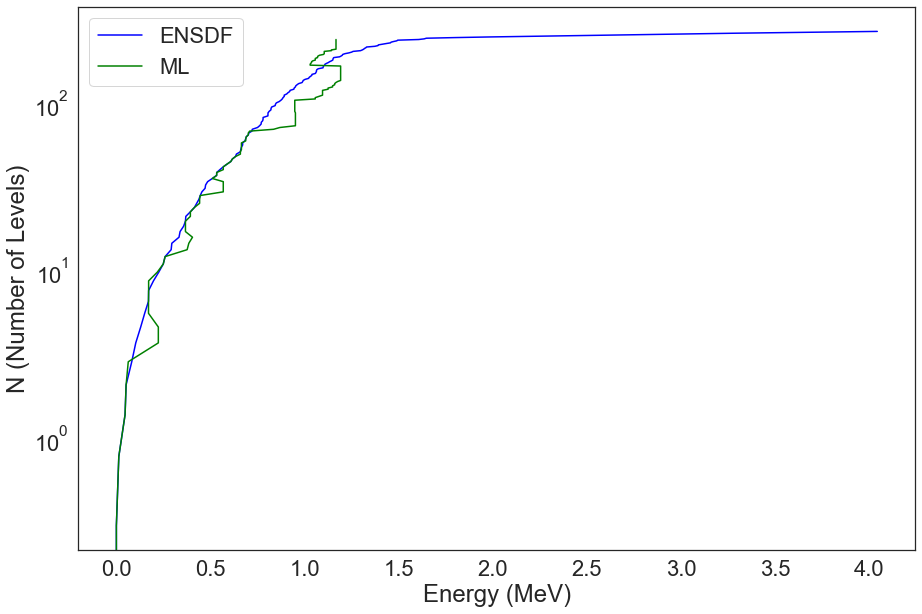

In [47]:
results_dict = ensdf_utils.predicting_nuclear_xs_v2(
    ensdf_df, 92, 235, dt_rgr, scaler, to_scale, log_sqrt=True, num_levels=140,
    plot=True, save=True, save_dir=figure_dir, inv_trans=True)

In [49]:
results_dict.keys()

dict_keys(['expanded', 'original', 'error_metrics'])

In [50]:
results_dict["error_metrics"]

,id,mae,mse,evs,mae_m,r2
0,EXFOR VS ML,0.094578,0.034748,0.696485,0.060688,0.684372


# DT Script

In [38]:
dt_saving_dir = '../Models/DT/'

In [39]:
if os.path.exists(dt_saving_dir):
    print("Directory Exists.")
else:
    print("Directory does not exists. Creating.")
    os.makedirs(dt_saving_dir)

Directory Exists.


In [ ]:
dt_parameters = {"max_depth_list":np.arange(5, 45, 5), 
                 "min_split_list":[2, 5, 10, 15], 
                 "min_leaf_list":[1, 3, 5, 7, 10]}

dt_results = model_building.train_dt(x_train, y_train, x_test, y_test, dt_parameters, 
                                     save_models=True, save_dir=dt_saving_dir)